In [43]:
library(ggplot2)
library(class)
library(gmodels)
library(reshape2)
library(dplyr)
library(rpart)
library(rpart.plot)
library(caret)

set.seed(42)
theme_set(theme_minimal())

In [2]:
df <- read.csv("data/kc_house_data.csv", stringsAsFactors = FALSE)

In [3]:
print(paste("rows:", nrow(df), "cols:", ncol(df)))

[1] "rows: 21613 cols: 21"


In [4]:
df <- df[-1]
df$date <- as.Date.character(df$date, format="%Y%M%d")
df$condition <- as.factor(df$condition)
df$grade <- as.factor(df$grade)

In [5]:
ggplot_missing <- function(x){
  
  x %>% 
    is.na %>%
    melt %>%
    ggplot(data = .,
           aes(x = Var2,
               y = Var1)) +
    geom_raster(aes(fill = value)) +
    scale_fill_grey(name = "",
                    labels = c("Present","Missing")) +
    theme(axis.text.x  = element_text(angle=45, vjust=0.5)) + 
    labs(x = "Variables in Dataset",
         y = "Rows / observations")
}

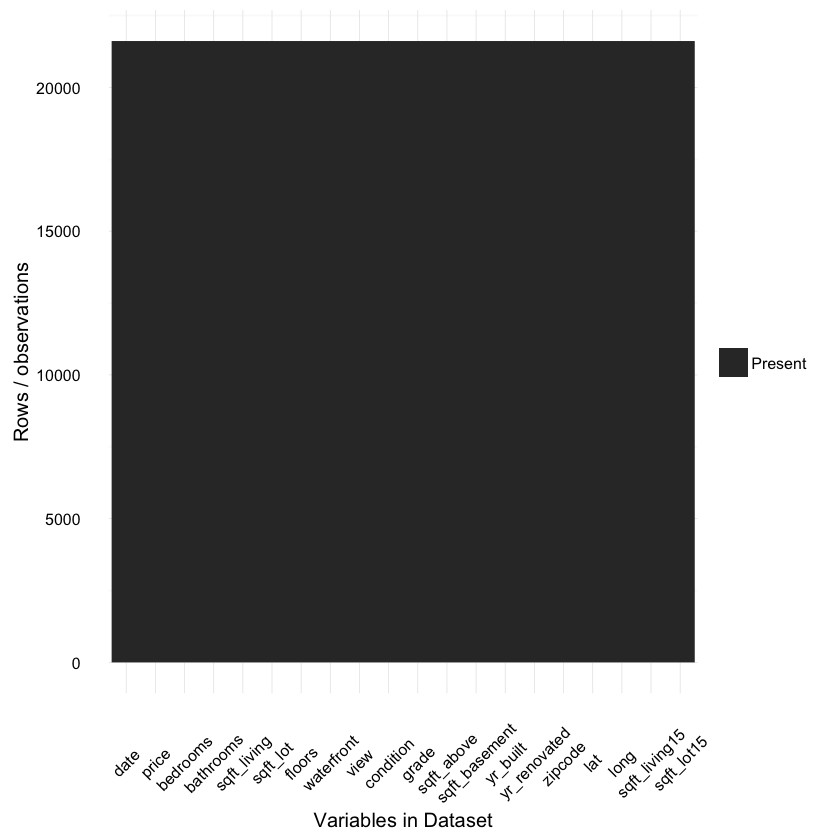

In [6]:
ggplot_missing(df)

In [ ]:
head(df)

In [ ]:
qplot(condition, data=df, geom = "bar", main="Number of houses by condition")

In [ ]:
qplot(grade, data=df, geom = "bar", main="Number of houses by grade")

In [ ]:
qplot(log10(price), data = df, geom = "density", main="Distribution of house prices (log10)")

In [ ]:
library(ggmap)

In [ ]:
qmap(location = "King County", zoom = 14, source = "osm")

In [ ]:
?qmap

Split to 70% training, 20% testing and 10% validation

In [150]:
train_idx <- sample(nrow(df), nrow(df) * 0.7, 
                    replace = FALSE)
train <- df[train_idx, ]

test_validation_idx <- seq(1:nrow(df))[-train_idx]
test_idx <- sample(test_validation_idx, nrow(df) * 0.2, replace = FALSE)
validation_idx <- setdiff(test_validation_idx, test_idx)

test <- df[test_idx, ]
validation <- df[validation_idx, ]

In [151]:
train_labels <- df[train_idx, 2]
test_labels <- df[test_idx, 2]
validation_labels <- df[validation_idx, 2]

In [126]:
colnames(df)

[1] "date"          "price"         "bedrooms"      "bathrooms"    
 [5] "sqft_living"   "sqft_lot"      "floors"        "waterfront"   
 [9] "view"          "condition"     "grade"         "sqft_above"   
[13] "sqft_basement" "yr_built"      "yr_renovated"  "zipcode"      
[17] "lat"           "long"          "sqft_living15" "sqft_lot15"

In [152]:
tree_fit <- rpart(log10(price) ~ ., data=df)

In [ ]:
# rpart.plot(tree_fit, digits = 3)
rpart.plot(tree_fit, digits = 4, fallen.leaves = TRUE,
             type = 3, extra = 101)

In [153]:
predicted <- predict(tree_fit, test)

In [ ]:
summary(predicted)

In [ ]:
summary(log10(test_labels))

In [ ]:
cor(predicted, log10(test_labels))

In [14]:
mean_squared_error <- function(actual, predicted) {
    mean(abs(actual - predicted))
}

In [154]:
mean_squared_error(predicted, log10(test_labels))

[1] 0.09920413

Enter `caret`

In [37]:
ctrl = trainControl(method="cv", number=10, allowParallel = TRUE)
in_train = createDataPartition(df$price, p=.9, list=FALSE)

In [155]:
trf = train(price ~ ., 
            data=df, method="xgbTree", metric="RMSE",
            trControl=ctrl, subset = in_train)

In [156]:
test = df[-in_train,]
# test$price <- log10(test$price)
pred = predict(trf, test, "raw")

In [157]:
mean_squared_error(pred, test$price)

[1] 70703.57

In [133]:
library(doMC)

In [60]:
registerDoMC(cores = 4)

In [146]:
imp <- varImp(trf, scale = FALSE)

In [147]:
imp_names = rev(rownames(imp$importance))
imp_vals = rev(imp$importance[, 1])

In [148]:
var_importance <- data_frame(variable=imp_names,
                             importance=imp_vals)
var_importance <- arrange(var_importance, importance)
var_importance$variable <- factor(var_importance$variable, levels=var_importance$variable)

p <- ggplot(var_importance, aes(x=variable, weight=importance))
p <- p + geom_bar(position="dodge") + ggtitle("Variable Importance from Random Forest Fit") + coord_flip()
p <- p + xlab("House Attribute") + ylab("Variable Importance (Mean Decrease in Gini Index)") 
p <- p + theme(legend.position="none")

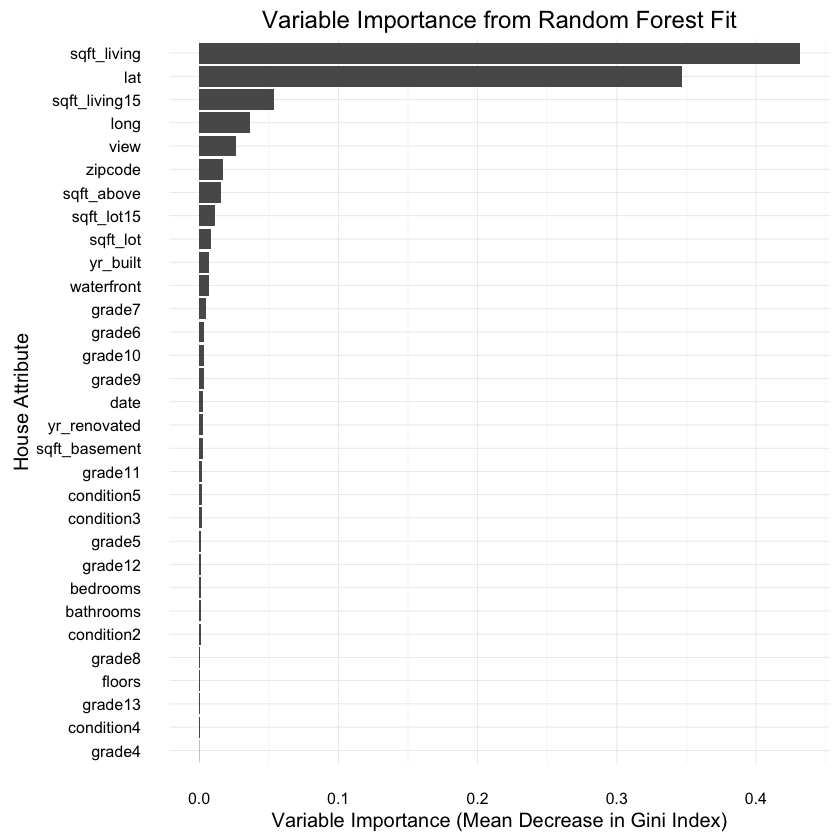

In [149]:
p